<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-model" data-toc-modified-id="Load-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load model</a></span></li><li><span><a href="#generate-random-peptides-from-proteome" data-toc-modified-id="generate-random-peptides-from-proteome-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>generate random peptides from proteome</a></span></li><li><span><a href="#read-MHC-alleles-belonging-to-the-split" data-toc-modified-id="read-MHC-alleles-belonging-to-the-split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>read MHC alleles belonging to the split</a></span></li><li><span><a href="#find-peptides-that-belong-to-the-MHC-alleles-in-the-data" data-toc-modified-id="find-peptides-that-belong-to-the-MHC-alleles-in-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>find peptides that belong to the MHC alleles in the data</a></span></li><li><span><a href="#find-highest-model-certainty-peptides-within-the-random-peptides" data-toc-modified-id="find-highest-model-certainty-peptides-within-the-random-peptides-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>find highest model certainty peptides within the random peptides</a></span></li><li><span><a href="#plot-motifs" data-toc-modified-id="plot-motifs-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>plot motifs</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import pdb
from argparse import ArgumentParser
import shlex
from tqdm import tqdm

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

import pMHC
from pMHC import SEP, FLANK_LEN, OUTPUT_FOLDER, \
    SPLITS, SPLIT_TRAIN, SPLIT_VAL, SPLIT_TEST, \
    VIEWS, VIEW_SA, VIEW_SAMA, VIEW_DECONV, \
    INPUT_PEPTIDE, INPUT_CONTEXT
from pMHC.logic import PresentationPredictor
from pMHC.data import from_data, to_input
from pMHC.data.example import Observation
from pMHC.data.mhc_allele import MhcAllele
from pMHC.data.datasets import StandardCollator

tqdm.pandas()

In [2]:
import torch
from pMHC.data import pseudo_pos
from pMHC.interpret.lime_based import MyExplainer
from pMHC.interpret.motif import generate_random_peptides_from_proteome

import random
from pMHC.data.protein import Protein

In [3]:
from collections import defaultdict

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

import logomaker as lm

In [5]:
pMHC.set_paths(r"/home/tux/Documents/MScProject")

Update project folder to: /home/tux/Documents/MScProject
Load permutation


In [6]:
mhc_alleles_filename = pMHC.SPLIT_MHC_ALLELES_TEST_FILENAME
# mhc_alleles_filename = pMHC.SPLIT_MHC_ALLELES_VAL_FILENAME

In [9]:
len_peptide = 9
num_random_peptides=100000

In [8]:
pMHC.data.from_input()

MhcAllele.from_input


MhcAlleles from input: 11074it [00:00, 19198.91it/s]


Protein.from_input


Proteins from input: 185930it [00:09, 18902.25it/s]


Sample.from_input


Samples from input: 472it [00:00, 17930.71it/s]


Peptide.from_input


Peptides from input: 429339it [00:22, 18721.49it/s]


Observation.from_input


Observations from input: 1959736it [01:39, 19649.29it/s]


# Load model

In [10]:
version = "CONTEXT-PSEUDO-HEAD_Cls-DECOY_19-LR_0.00001"
checkpoint = "epoch=4-step=3648186"

In [11]:
MODEL_PATH = f"{pMHC.OUTPUT_FOLDER}{SEP}main{SEP}{version}{SEP}checkpoints{SEP}{checkpoint}.ckpt"
model = PresentationPredictor.load_from_checkpoint(MODEL_PATH, num_workers=0, 
                                                   name="mod", version="vers", shuffle_data=False,
                                                   output_attentions=True,
                                                   only_deconvolute=True
                                                  ) # can 
                                                    # soon be removed

Global seed set to 42


# generate random peptides from proteome

In [12]:
n_flanks, peptides, c_flanks = generate_random_peptides_from_proteome(
    len_peptide=len_peptide, length=num_random_peptides)

100%|██████████| 100000/100000 [03:45<00:00, 443.54it/s]


In [12]:
counts_mat = lm.alignment_to_matrix(peptides)
counts_mat = counts_mat[['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']]
counts_mat.index = counts_mat.index + 1
prop_mat = counts_mat/np.sum(counts_mat, axis=0)
prop_mat

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
pos,,,,,,,,,,,,,,,,,,,,
1,0.112608,0.109489,0.113283,0.109698,0.111881,0.109300,0.108068,0.111826,0.110659,0.110842,0.138533,0.109958,0.112206,0.106993,0.108796,0.109960,0.109288,0.110863,0.110922,0.110427
2,0.111610,0.109161,0.114546,0.111856,0.110507,0.111837,0.110275,0.110283,0.111383,0.111609,0.106940,0.111666,0.113445,0.111797,0.109839,0.111358,0.108461,0.109465,0.107767,0.111301
3,0.112047,0.105735,0.110878,0.112456,0.108746,0.112410,0.109972,0.112140,0.109465,0.111116,0.107216,0.111022,0.110608,0.113454,0.111794,0.112358,0.111090,0.111371,0.106068,0.110635
4,0.110144,0.113338,0.110950,0.111612,0.109821,0.111444,0.111573,0.110518,0.111579,0.113590,0.109637,0.110183,0.108041,0.109786,0.109671,0.111358,0.111641,0.111371,0.110275,0.115129
5,0.111828,0.110099,0.110116,0.109308,0.112986,0.111624,0.110275,0.112637,0.114456,0.109627,0.107161,0.111022,0.110698,0.110188,0.111589,0.111906,0.110560,0.111244,0.115615,0.110510
6,0.111158,0.111460,0.110307,0.110882,0.110239,0.110298,0.113130,0.108897,0.111266,0.110186,0.104464,0.111763,0.112081,0.111513,0.111831,0.110412,0.113486,0.113097,0.114725,0.111883
7,0.112998,0.111789,0.112617,0.111466,0.109194,0.111624,0.112741,0.110100,0.109817,0.110021,0.106940,0.111215,0.111398,0.111821,0.111421,0.112399,0.110793,0.109864,0.116100,0.108097
8,0.110082,0.113619,0.109521,0.111726,0.113314,0.111084,0.112870,0.111434,0.108603,0.111543,0.111729,0.112182,0.108651,0.112578,0.112557,0.111303,0.112192,0.110936,0.108010,0.109095
9,0.107525,0.115309,0.107782,0.110996,0.113314,0.110380,0.111097,0.112166,0.112773,0.111466,0.107381,0.110989,0.112871,0.111868,0.112501,0.108946,0.112489,0.111789,0.110518,0.112923


In [13]:
with open(f"{pMHC.OUTPUT_FOLDER}{SEP}motifs{SEP}random_peptides.txt", 'w') as file:
    file.write(", ".join(peptides))

# read MHC alleles belonging to the split

In [13]:
with open(mhc_alleles_filename, 'r') as file:
    mhc_allele_groups = file.read()
mhc_allele_groups = mhc_allele_groups.split("; ")

In [15]:
mhc_allele_groups

['HLA-C17',
 'HLA-C01',
 'HLA-C15',
 'HLA-B58',
 'HLA-B37',
 'HLA-A33',
 'HLA-A36',
 'HLA-A74',
 'HLA-B46',
 'HLA-B54']

In [15]:
mhc_alleles = defaultdict(lambda: [])
for obs in Observation.observations:
    if len(obs.sample.mhc_alleles) == 1 and len(obs.peptide.seq) == len_peptide:
        if obs.sample.mhc_alleles[0].name[:7] in mhc_allele_groups:
            mhc_alleles[obs.sample.mhc_alleles[0].name].append(obs)

# find peptides that belong to the MHC alleles in the data

In [36]:
for mhc_allele_name, liste in mhc_alleles.items():
    print(f"{mhc_allele_name}: {len(liste)}")
    
    text = ""
    for obs in liste:
        text += f"{obs.peptide.seq}\n"
    
    with open(f"{pMHC.OUTPUT_FOLDER}{SEP}motifs{SEP}motif_{mhc_allele_name.replace(':', '')}_actual.txt", 'w') as file:
        file.write(text)

HLA-A33:01: 1945
HLA-C01:02: 2861
HLA-C15:02: 5823
HLA-C17:01: 2453
HLA-A36:01: 971
HLA-B58:01: 1273
HLA-A74:01: 1476
HLA-B58:02: 806
HLA-A33:03: 1978
HLA-B37:01: 1016
HLA-B54:01: 532
HLA-B46:01: 828


# find highest model certainty peptides within the random peptides

In [17]:
model.to("cuda")

PresentationPredictor(
  (backbone_): TAPEBackbone(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(5, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ProteinBertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm()
              (dropout): D

In [34]:
checkpoint

'epoch=4-step=3648186'

In [30]:
collator = StandardCollator(model)

model.eval()
for mhc_allele_name in mhc_alleles.keys():
    print(mhc_allele_name)
    mhc_allele = pMHC.data.mhc_allele.MhcAllele.mhc_alleles[mhc_allele_name]
    
    idx = 0
    preds = []
    while idx < num_random_peptides:
        examples = []
        while len(examples) < model.batch_size and idx < num_random_peptides:
            example = pMHC.data.utils.get_input_rep_PSEUDO(n_flanks[idx], peptides[idx], c_flanks[idx], mhc_allele.pseudo_seq, model)
            examples.append(example)
            idx += 1

        batch = collator(examples)
        pMHC.data.utils.move_dict_to_device(batch, model)
        y_hat = torch.sigmoid(model(batch)).detach().cpu().numpy()
        for i in range(y_hat.shape[0]):
            preds.append(float(y_hat[i]))
            
    df = pd.DataFrame({"n_flank": n_flanks, "peptide": peptides, "c_flank": c_flanks, "pred": preds})
    df_sorted = df.sort_values("pred", ascending=False)
    
    text = ""
    for idx, (peptide, pred) in df_sorted[["peptide", 'pred']].iterrows(): #[:int(num_random_peptides*0.005)]:
        if pred > 0.5:
            text += f"{peptide}\n"
        
    with open(f"{pMHC.OUTPUT_FOLDER}{SEP}motifs{SEP}motif_{mhc_allele_name.replace(':', '')}_{checkpoint}.txt", 'w') as file:
        file.write(text)

HLA-A33:01
HLA-C01:02
HLA-C15:02
HLA-C17:01
HLA-A36:01
HLA-B58:01
HLA-A74:01
HLA-B58:02
HLA-A33:03
HLA-B37:01
HLA-B54:01
HLA-B46:01


https://weblogo.berkeley.edu/logo.cgi

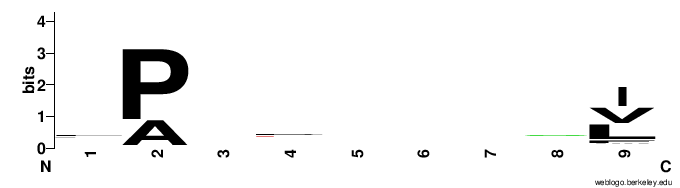

# plot motifs

In [37]:
checkpoints = ["epoch=4-step=3648186", "actual"]

/home/tux/miniconda3/envs/MScProject/lib/python3.8/site-packages/logomaker/src/Logo.py:194: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=self.figsize)


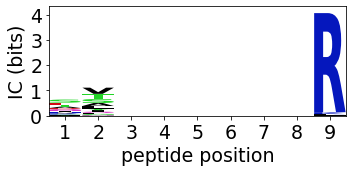

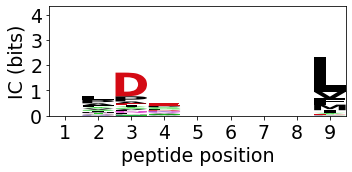

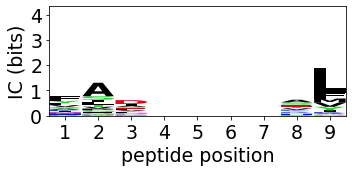

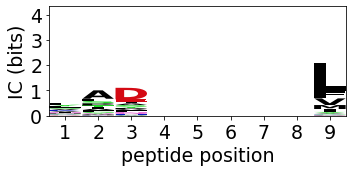

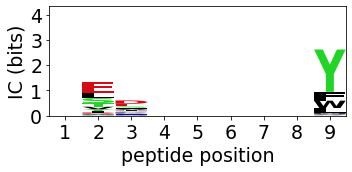

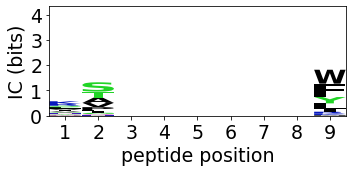

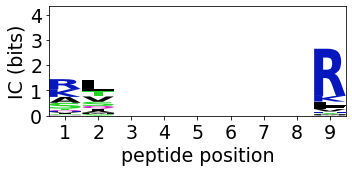

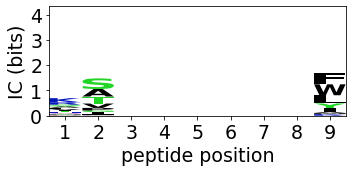

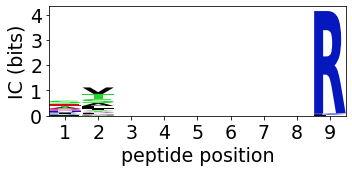

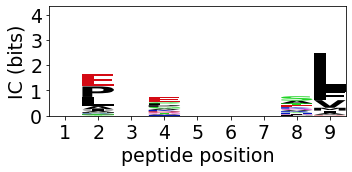

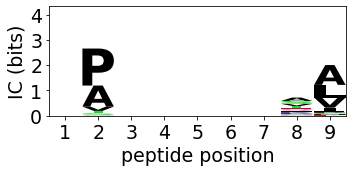

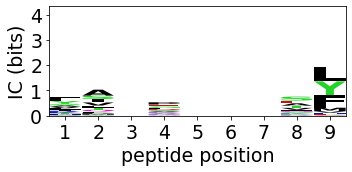

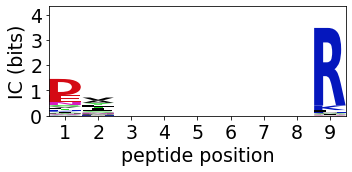

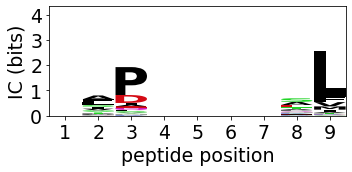

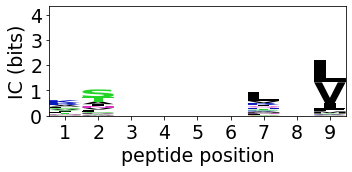

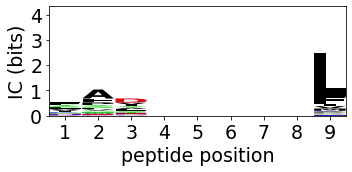

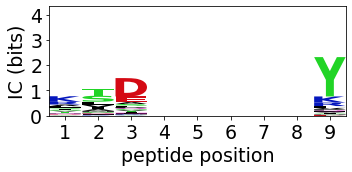

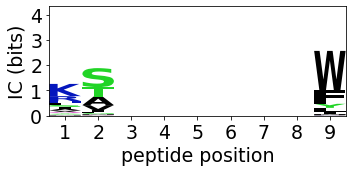

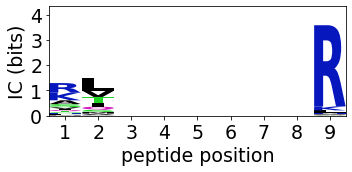

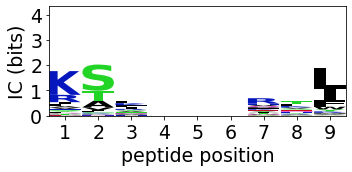

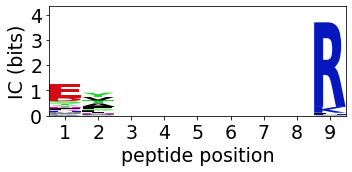

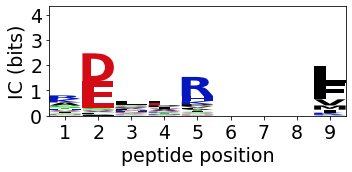

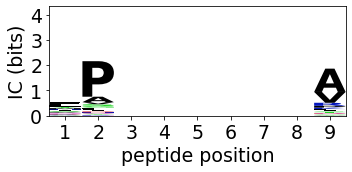

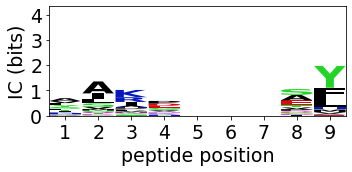

In [38]:
color_scheme = "weblogo_protein"
fontsize=19
aa_cnt = 20
for checkpoint in checkpoints:
    for mhc_allele_name in mhc_alleles.keys():
        motif_filename = f"{pMHC.OUTPUT_FOLDER}{SEP}motifs{SEP}motif_{mhc_allele_name.replace(':', '')}_{checkpoint}.txt"
        with open(motif_filename, 'r') as file:
            peptides_model = file.read()
        peptides_model = [x for x in peptides_model.split("\n")[:-1] if all([h in "ACDEFGHIKLMNPQRSTVWY" for h in x])]

        counts_mat = lm.alignment_to_matrix(peptides_model)
        aa_cnt = counts_mat.shape[1]
        counts_mat.index = counts_mat.index + 1
        prop_mat = counts_mat/np.sum(counts_mat.iloc[0])
        entropy = prop_mat.apply(lambda row: -np.sum([np.log2(x) * x for x in row if x > 0]), axis=1)
        IC = np.log2(aa_cnt) - entropy
        IC[IC < 0.5] = 0
        IC_mat = prop_mat * np.broadcast_to(np.array(IC).reshape((9, 1)), (9, aa_cnt))

        logo = lm.Logo(IC_mat, color_scheme=color_scheme, figsize=(5, 2.5))
        logo.ax.set_ylim([0, np.log2(aa_cnt)])
        logo.ax.set_ylabel(f'IC (bits)', fontsize=fontsize)
        logo.ax.set_xlabel('peptide position', fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.margins(0,0)
        # rect=matplotlib.patches.Rectangle((0,0), 10, 0.25, linewidth=0, edgecolor='r', facecolor='white')
        # logo.ax.add_patch(rect)
        plt.tight_layout()
        
        plt.savefig(f"{pMHC.OUTPUT_FOLDER}{SEP}motifs{SEP}pics{SEP}{mhc_allele_name.replace(':', '')}_{checkpoint}.png",
                   format="png")
        